In [132]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sb
import matplotlib.pyplot as plt

In [133]:
# Load data
df = pd.read_csv('creditcard.csv')

# Check for missing values
if df.isnull().values.any():
    df = df.dropna()  # Drop rows with any missing values if any

# Drop irrelevant feature
df.drop('Time', axis=1, inplace=True)

In [134]:
# Separate features and labels
X = df.drop('Class', axis=1)
y = df['Class']

# Filter the data to have only normal transactions for training
normal_data = df[df['Class'] == 0]
fraud_data = df[df['Class'] == 1]


In [135]:
# Split the normal data into training and test sets
X_train, X_test_normal, _, y_test_normal = train_test_split(
    normal_data.drop('Class', axis=1), normal_data['Class'], test_size=0.2, random_state=42)

# Include all fraud transactions and a portion of normal transactions in the test set
X_test = pd.concat([X_test_normal, fraud_data.drop('Class', axis=1)])
y_test = pd.concat([y_test_normal, fraud_data['Class']])


In [144]:
# # Normalize the data
scaler = StandardScaler()
# df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# X_test = X_test.to_numpy()
# X_train = X_train.to_numpy()


# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Define datasets
train_data = TensorDataset(X_train_tensor, X_train_tensor)
test_data = TensorDataset(X_test_tensor, X_test_tensor)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [120]:
# dff = pd.DataFrame(X_train_scaled)
# dff2 = pd.DataFrame(X_test_scaled)

# # print(dff.describe())
# print(dff2.max().max())

103.71918812127969


# Basic AE

In [149]:
# Define the AutoEncoder model
class AutoEncoder(nn.Module):
    def __init__(self, input_size):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 14),
            nn.Tanh(),
            nn.Linear(14, 7),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(7, 14),
            nn.Tanh(),
            nn.Linear(14, input_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Initialize the model, loss function, and optimizer
input_size = X.shape[1]
learning_rate = 0.001

model = AutoEncoder(input_size)
#model.load_state_dict(torch.load('autoencoder_model_weights3.pth'))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [150]:
# Training the model
def train_model(model, dataloader):
    model.train()
    total_loss = 0
    for data, _ in dataloader:
        
        output = model(data)

        loss = criterion(output, data)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        
    return total_loss / len(dataloader)

Epoch [1/20], Loss:0.8947
Epoch [2/20], Loss:0.8304
Epoch [3/20], Loss:0.8141
Epoch [4/20], Loss:0.8058
Epoch [5/20], Loss:0.7995
Epoch [6/20], Loss:0.7950
Epoch [7/20], Loss:0.7915
Epoch [8/20], Loss:0.7896
Epoch [9/20], Loss:0.7882
Epoch [10/20], Loss:0.7871
Epoch [11/20], Loss:0.7862
Epoch [12/20], Loss:0.7845
Epoch [13/20], Loss:0.7830
Epoch [14/20], Loss:0.7816
Training stopped after 14 epochs due to exceeded patience.


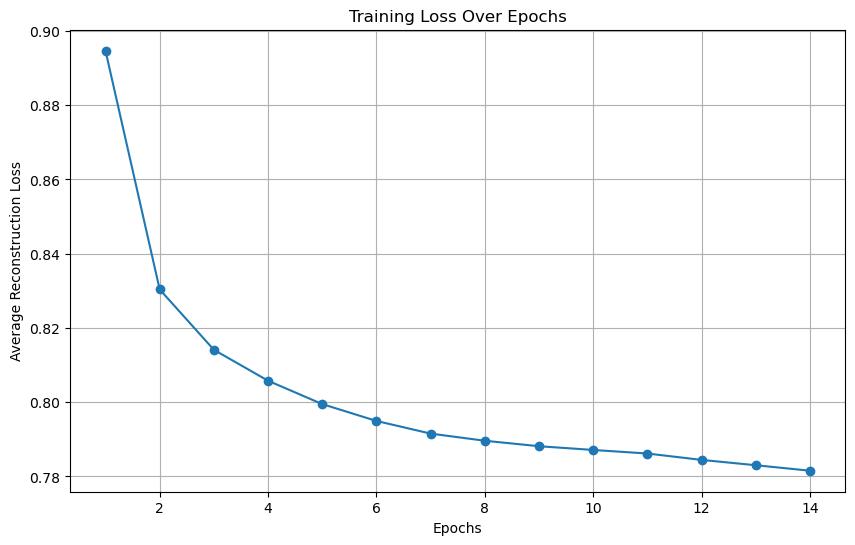

In [151]:
# Train the AutoEncoder
epoch_losses = []
epochs = 20

best_loss = float('inf')
patience_counter = 0
patience=5
min_delta=0.01

for epoch in range(epochs):

    loss = train_model(model, train_loader)

    epoch_losses.append(loss)
    
    print('Epoch [{}/{}], Loss:{:.4f}'
          .format(epoch + 1, epochs, loss))
    
    # Check for improvement
    if best_loss - loss > min_delta:
        best_loss = loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Check if patience has run out
    if patience_counter >= patience:
        print(f'Training stopped after {epoch+1} epochs due to exceeded patience.')
        break

# Plot the training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Average Reconstruction Loss')
plt.grid(True)
plt.show()

In [152]:
# Modify the evaluation function to return actual loss values per instance
def evaluate_model(model, dataloader, criterion):

    model.eval()
    losses = []

    with torch.inference_mode():

        for data, _ in dataloader:

            output = model(data)

            loss = criterion(output, data)

            # losses.append(loss.item())
            losses.extend(loss.item() for _ in range(data.size(0)))

    return losses


In [153]:
# Evaluate model to get losses for each instance in the train set
train_loss = evaluate_model(model, train_loader, criterion)
average_train_loss = np.mean(train_loss)
print(f'Average Training Reconstruction Loss: {average_train_loss}')

# Evaluate model to get losses for each instance in the test set
test_losses = evaluate_model(model, test_loader, criterion)
average_test_loss = np.mean(test_losses)
print(f'Average Test Reconstruction Loss: {average_test_loss}')

# Determine the threshold for anomaly detection (setting at the 95th percentile of test losses)
threshold = np.percentile(test_losses, 95)
print(f'Anomaly Detection Threshold: {threshold}')

Average Training Reconstruction Loss: 0.7810297603564242
Average Test Reconstruction Loss: 1.0015743720272696
Anomaly Detection Threshold: 1.5130507946014404


Accuracy: 0.9586958416877343, 
Precision: 0.17173837005946135, 
Recall: 0.9979674796747967, 
F1 Score: 0.29304685168606387


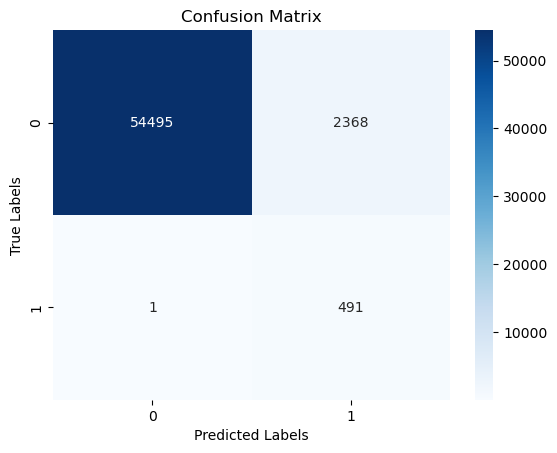

Area Under Curve (AUC): 0.9984072579809209


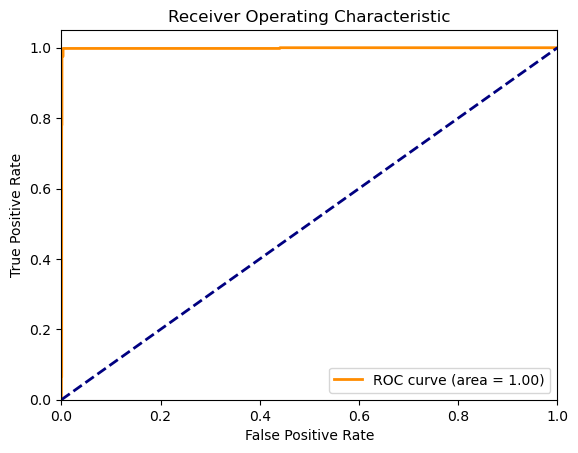

In [154]:
# Generate binary predictions based on the threshold
predicted_anomalies = np.array([1 if loss > threshold else 0 for loss in test_losses])
actual_anomalies = y_test.to_numpy()

# Calculate evaluation metrics
accuracy = accuracy_score(actual_anomalies, predicted_anomalies)
precision = precision_score(actual_anomalies, predicted_anomalies)
recall = recall_score(actual_anomalies, predicted_anomalies)
f1 = f1_score(actual_anomalies, predicted_anomalies)

print(f'Accuracy: {accuracy}, \nPrecision: {precision}, \nRecall: {recall}, \nF1 Score: {f1}')

# Plotting the confusion matrix
conf_matrix = confusion_matrix(actual_anomalies, predicted_anomalies)
sb.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(actual_anomalies, test_losses)
roc_auc = auc(fpr, tpr)
# Print the AUC
print(f'Area Under Curve (AUC): {roc_auc}')

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [164]:
# # Save the model's state dictionary
#torch.save(model.state_dict(), 'autoencoder_model_weights4.pth')


TypeError: Module.state_dict() missing 1 required positional argument: 'self'

# Sparse AE

In [158]:
class SparseAutoEncoder(nn.Module):
    def __init__(self, input_size, sparsity_target=0.05, sparsity_weight=1e-3):
        super(SparseAutoEncoder, self).__init__()

        self.sparsity_target = sparsity_target
        self.sparsity_weight = sparsity_weight

        self.encoder = nn.Sequential(
            nn.Linear(input_size, 14),
            nn.Tanh(),
            nn.Linear(14, 7),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            # nn.Linear(7, 7),
            # nn.ReLU(),
            nn.Linear(7, 14),
            nn.Tanh(),
            nn.Linear(14, input_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded
    
    def sparsity_penalty(self, encoded):
        # Mean activation per neuron in the batch
        mean_activation = torch.mean(encoded, dim=0)
        # KL divergence between the target sparsity and the mean activation
        epsilon = 1e-10
        kl_div = self.sparsity_target * torch.log((self.sparsity_target + epsilon) / (mean_activation + epsilon)) + \
                (1 - self.sparsity_target) * torch.log(((1 - self.sparsity_target + epsilon) / (1 - mean_activation + epsilon)))

        kl_div = torch.sum(kl_div)  # Average over all neurons in the layer
        return kl_div

# Initialize the model, loss function, and optimizer
input_size = X.shape[1]
sparsity_target = 0.4
sparsity_weight = 0.3
learning_rate = 0.001
    
model = SparseAutoEncoder(input_size, sparsity_target, sparsity_weight)
# model.load_state_dict(torch.load('sparse_autoencoder_model_weights.pth'))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# l1_regularization_strength = 0.0001

In [159]:
def train_model(model, dataloader, l1_strength, optimizer):

    model.train()
    total_loss = 0

    for data, _ in dataloader:

        decoded, encoded = model(data)

        reconstruction_loss = criterion(decoded, data)
        sparsity_loss = model.sparsity_penalty(encoded)

        # l1_loss = l1_strength * torch.norm(encoded, p=1)
        # loss = reconstruction_loss + l1_loss
        loss = reconstruction_loss + model.sparsity_weight * sparsity_loss
        
        optimizer.zero_grad()

        loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


Epoch [1/20], Loss:0.9412
Epoch [2/20], Loss:0.8451
Epoch [3/20], Loss:0.8219
Epoch [4/20], Loss:0.8124
Epoch [5/20], Loss:0.8073
Epoch [6/20], Loss:0.8031
Epoch [7/20], Loss:0.7989
Epoch [8/20], Loss:0.7962
Epoch [9/20], Loss:0.7945
Epoch [10/20], Loss:0.7933
Epoch [11/20], Loss:0.7925
Epoch [12/20], Loss:0.7918
Epoch [13/20], Loss:0.7912
Training stopped after 13 epochs due to exceeded patience.


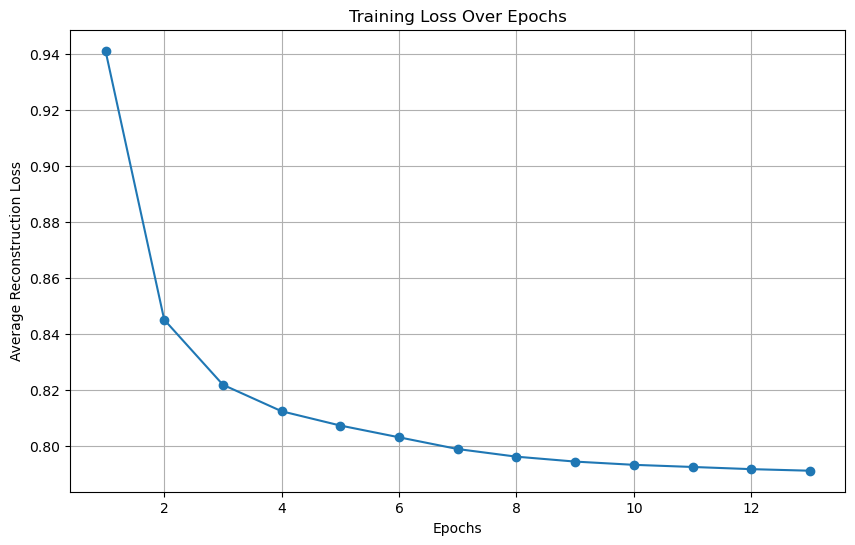

In [160]:
# Train the Sparse AutoEncoder
epoch_losses = []
epochs = 20

best_loss = float('inf')
patience_counter = 0
patience=5
min_delta=0.01


for epoch in range(epochs):
    # loss = train_model(model, train_loader, l1_regularization_strength)
    loss = train_model(model, train_loader, criterion, optimizer)

    epoch_losses.append(loss)
    
    print('Epoch [{}/{}], Loss:{:.4f}'
          .format(epoch + 1, epochs, loss))
    

    # Check for improvement
    if best_loss - loss > min_delta:
        best_loss = loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Check if patience has run out
    if patience_counter >= patience:
        print(f'Training stopped after {epoch+1} epochs due to exceeded patience.')
        break

# Plot the training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Average Reconstruction Loss')
plt.grid(True)
plt.show()

In [161]:
# Modify the evaluation function to return actual loss values per instance
def evaluate_model(model, dataloader, criterion):
    model.eval()
    losses = []
    with torch.inference_mode():
        for data, _ in dataloader:
            output, _ = model(data)
            loss = criterion(output, data)
            losses.extend(loss.item() for _ in range(data.size(0)))
    return losses

In [162]:
# Evaluate model to get losses for each instance in the train set
train_loss = evaluate_model(model, train_loader, criterion)
average_train_loss = np.mean(train_loss)
print(f'Average Training Reconstruction Loss: {average_train_loss}')

# Evaluate model to get losses for each instance in the test set
test_losses = evaluate_model(model, test_loader, criterion)
average_test_loss = np.mean(test_losses)
print(f'Average Test Reconstruction Loss: {average_test_loss}')

# Determine the threshold for anomaly detection (setting at the 95th percentile of test losses)
threshold = np.percentile(test_losses, 95)
hard_threshold = 1.5
print(f'Anomaly Detection Threshold: {threshold}')
print(f'Reference Threshold: {hard_threshold}')

Average Training Reconstruction Loss: 0.7893016376147018
Average Test Reconstruction Loss: 1.0099848382278243
Anomaly Detection Threshold: 1.5278106927871704
Reference Threshold: 1.5


Accuracy: 0.9564641269287769, 
Precision: 0.1643789755607633, 
Recall: 0.9979674796747967, 
F1 Score: 0.28226501868352977


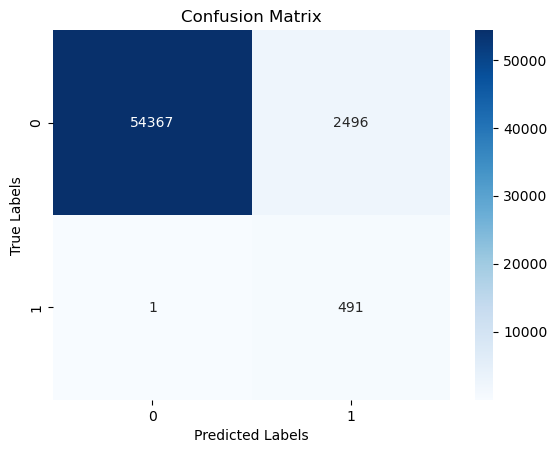

Area Under Curve (AUC): 0.9984335656846888


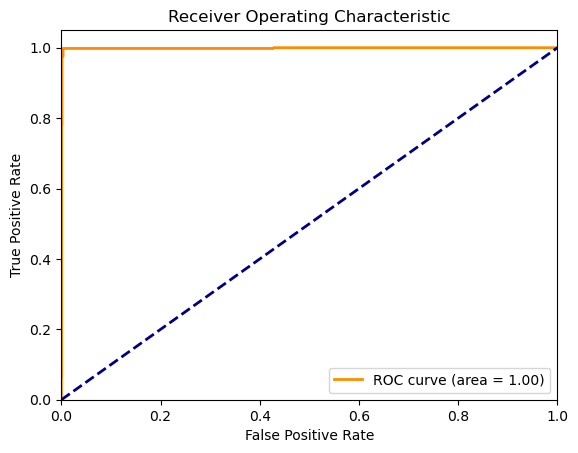

In [163]:
# Generate binary predictions based on the threshold
predicted_anomalies = np.array([1 if loss > hard_threshold else 0 for loss in test_losses])
actual_anomalies = y_test.to_numpy()


# Calculate evaluation metrics
accuracy = accuracy_score(actual_anomalies, predicted_anomalies)
precision = precision_score(actual_anomalies, predicted_anomalies)
recall = recall_score(actual_anomalies, predicted_anomalies)
f1 = f1_score(actual_anomalies, predicted_anomalies)

print(f'Accuracy: {accuracy}, \nPrecision: {precision}, \nRecall: {recall}, \nF1 Score: {f1}')

# Plotting the confusion matrix
conf_matrix = confusion_matrix(actual_anomalies, predicted_anomalies)
sb.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(actual_anomalies, test_losses)
roc_auc = auc(fpr, tpr)
# Print the AUC
print(f'Area Under Curve (AUC): {roc_auc}')

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [165]:
#torch.save(model.state_dict(), 'sparse_autoencoder_model_weights1.pth')

## Variational AE

In [23]:
# Variational Autoencoder Definition
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(X.shape[1], 14),
            nn.LeakyReLU(),
            nn.Linear(14, 7),
            nn.LeakyReLU()
        )
        
        self.mu = nn.Linear(7, 3)
        self.log_var = nn.Linear(7, 3)
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 7),
            nn.LeakyReLU(),
            nn.Linear(7, 14),
            nn.LeakyReLU(),
            nn.Linear(14, X.shape[1]),
            nn.Tanh()
        )
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

model = VAE()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
# Training Function
def train_model(model, dataloader):
    model.train()
    total_loss = 0
    for data, target in dataloader:
        print(target)
        reconstructed, mu, log_var = model(data)

        mse_loss = criterion(reconstructed, target)
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = mse_loss + kl_loss

        optimizer.zero_grad()

        loss.backward()

        total_loss += loss.item()   
        
        optimizer.step()

        
        
    return total_loss / len(dataloader)


In [26]:
# Training the VAE
epochs = 50
epoch_losses = []
for epoch in range(epochs):
    loss = train_model(model, train_loader)
    epoch_losses.append(loss)
    print(f'Epoch {epoch+1}, Loss: {loss}')

# Plot the training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), epoch_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Average Reconstruction Loss')
plt.grid(True)
plt.show()

tensor([[ 1.0268e+00, -4.6685e-01, -8.6303e-01, -2.7537e-01, -4.4602e-01,
         -7.7665e-01, -1.3863e-01, -1.9559e-01,  1.6319e+00, -4.6164e-01,
         -1.3225e+00,  9.0758e-02, -1.2481e+00,  4.1377e-02, -7.8875e-01,
         -1.2385e+00,  5.1667e-01, -5.4041e-01,  7.5313e-01, -2.7914e-01,
          3.5206e-01,  1.4708e+00, -2.0194e-01,  1.8330e-01,  5.2161e-01,
          2.2155e+00, -1.9555e-01, -2.2310e-01, -1.7416e-01],
        [ 5.3413e-01, -5.4530e-01,  8.4753e-01,  6.0016e-01, -1.2157e+00,
          4.9963e-02, -8.9613e-01,  2.0275e-01, -1.3109e-01,  6.4788e-01,
         -6.8120e-01, -6.2579e-01, -1.2123e+00, -6.1310e-02,  9.1625e-01,
         -1.8138e+00,  4.1252e-01,  1.4444e+00, -2.1471e+00, -6.5327e-01,
         -2.1340e-01, -5.4403e-02,  7.7275e-03,  5.7497e-01,  3.7268e-01,
         -4.8831e-01,  2.1389e-01,  1.5704e-01,  2.1372e-02],
        [-1.8324e-01,  5.3297e-01,  9.5325e-01,  4.5986e-01,  2.1694e-01,
          1.1897e-01,  5.9771e-01, -1.8138e-01, -3.1963e-02,  

RuntimeError: all elements of target should be between 0 and 1

In [47]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    losses = []
    with torch.inference_mode():
        for data, _ in dataloader:
            reconstructed, mu, log_var = model(data)
            mse_loss = criterion(reconstructed, data)
            kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            total_loss = mse_loss + kl_loss
            losses.extend(total_loss.item() for _ in range(data.size(0)))
    return losses

In [48]:
# Evaluate model to get losses for each instance in the train set
train_loss = evaluate_model(model, train_loader, criterion)
average_train_loss = np.mean(train_loss)
print(f'Average Training Reconstruction Loss: {average_train_loss}')

# Evaluate model to get losses for each instance in the test set
test_losses = evaluate_model(model, test_loader, criterion)
average_test_loss = np.mean(test_losses)
print(f'Average Test Reconstruction Loss: {average_test_loss}')

# Determine the threshold for anomaly detection (setting at the 95th percentile of test losses)
threshold = np.quantile(test_losses, 0.95)
print(f'Anomaly Detection Threshold: {threshold}')

Average Training Reconstruction Loss: 1.0000024431898087
Average Test Reconstruction Loss: 1.2170860358534108
Anomaly Detection Threshold: 1.7696914672851562


Accuracy: 0.9586958416877343, 
Precision: 0.17173837005946135, 
Recall: 0.9979674796747967, 
F1 Score: 0.29304685168606387


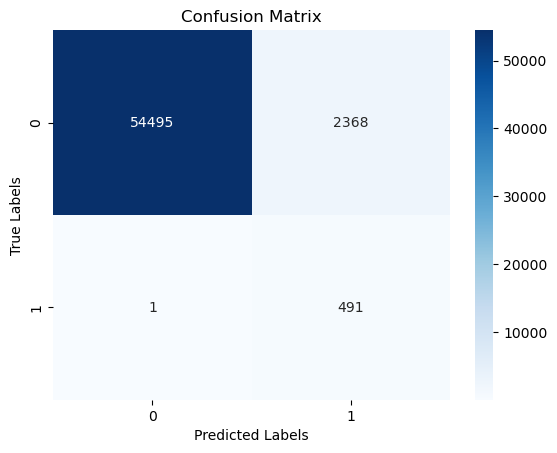

In [49]:
# Generate binary predictions based on the threshold
predicted_anomalies = np.array([1 if loss > threshold else 0 for loss in test_losses])
actual_anomalies = y_test.to_numpy()

# Calculate evaluation metrics
accuracy = accuracy_score(actual_anomalies, predicted_anomalies)
precision = precision_score(actual_anomalies, predicted_anomalies)
recall = recall_score(actual_anomalies, predicted_anomalies)
f1 = f1_score(actual_anomalies, predicted_anomalies)

print(f'Accuracy: {accuracy}, \nPrecision: {precision}, \nRecall: {recall}, \nF1 Score: {f1}')

# Plotting the confusion matrix
conf_matrix = confusion_matrix(actual_anomalies, predicted_anomalies)
sb.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Area Under Curve (AUC): 0.9982070906696441


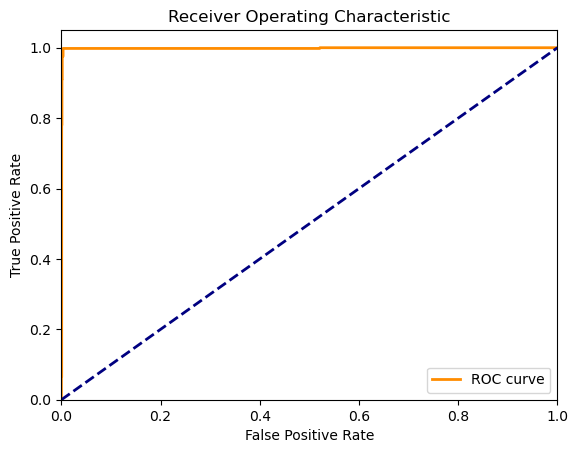

In [51]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(actual_anomalies, test_losses)
roc_auc = auc(fpr, tpr)

# Print the AUC
print(f'Area Under Curve (AUC): {roc_auc}')

# Plotting the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## GPETEK

In [180]:
# Define the Variational AutoEncoder model
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super(VariationalAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 14),
            nn.ReLU(),
            nn.Linear(14, 7),
            nn.ReLU()
        )
        # Latent space distribution parameters
        self.fc_mu = nn.Linear(7, 7)
        self.fc_logvar = nn.Linear(7, 7)

        self.decoder = nn.Sequential(
            nn.Linear(7, 14),
            nn.ReLU(),
            nn.Linear(14, input_dim),
            nn.Sigmoid()
        )
        self.criterion = nn.MSELoss()  # Choose based on your output activation and data processing

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return decoded, mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        MSE = self.criterion(recon_x, x)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return MSE + KLD

# Initialize the model, loss function, and optimizer
input_dim = X.shape[1]  # X should be defined as your input feature matrix
learning_rate = 0.001

model = VariationalAutoEncoder(input_dim)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [181]:
# Training the model
def train_model(model, dataloader, optimizer):

    model.train()
    total_loss = 0

    for data, _ in dataloader:

        recon_batch, mu, logvar = model(data)

        loss = model.loss_function(recon_batch, data, mu, logvar)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

Epoch [1/20], Loss:1.1090
Epoch [2/20], Loss:1.0000
Epoch [3/20], Loss:1.0000
Epoch [4/20], Loss:1.0000
Epoch [5/20], Loss:1.0000
Epoch [6/20], Loss:1.0000
Epoch [7/20], Loss:1.0000
Training stopped after 7 epochs due to exceeded patience.


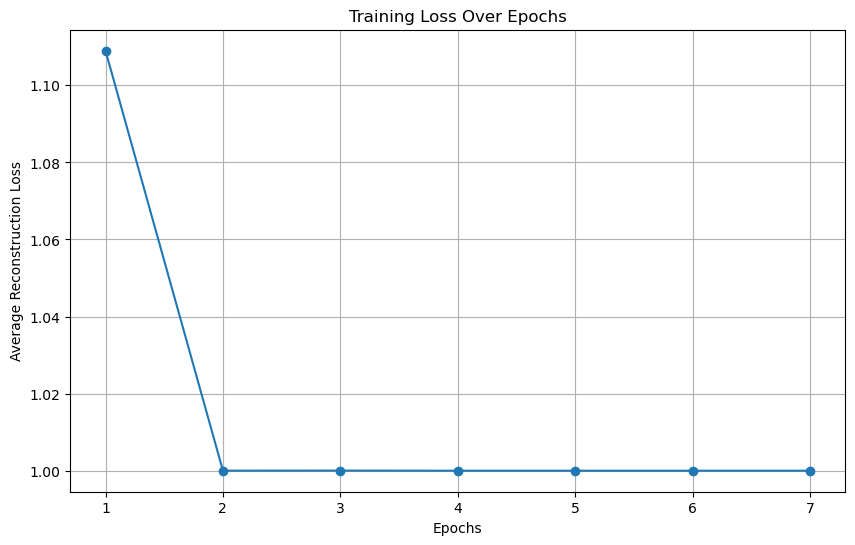

In [182]:
# Train the Sparse AutoEncoder
epoch_losses = []
epochs = 20

best_loss = float('inf')
patience_counter = 0
patience=5
min_delta=0.01


for epoch in range(epochs):

    loss = train_model(model, train_loader, optimizer)

    epoch_losses.append(loss)
    
    print('Epoch [{}/{}], Loss:{:.4f}'
          .format(epoch + 1, epochs, loss))
    

    # Check for improvement
    if best_loss - loss > min_delta:
        best_loss = loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Check if patience has run out
    if patience_counter >= patience:
        print(f'Training stopped after {epoch+1} epochs due to exceeded patience.')
        break

# Plot the training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Average Reconstruction Loss')
plt.grid(True)
plt.show()

In [183]:
# Evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    losses = []
    with torch.inference_mode():
        for data, _ in dataloader:
            recon, mu, logvar = model(data)
            loss = model.loss_function(recon, data, mu, logvar)
            losses.extend([loss.item()] * data.size(0))
    return losses

In [185]:
# Evaluate model to get losses for each instance in the train set
train_loss = evaluate_model(model, train_loader, )
average_train_loss = np.mean(train_loss)
print(f'Average Training Reconstruction Loss: {average_train_loss}')

# Evaluate model to get losses for each instance in the test set
test_losses = evaluate_model(model, test_loader, )
average_test_loss = np.mean(test_losses)
print(f'Average Test Reconstruction Loss: {average_test_loss}')

# Determine the threshold for anomaly detection (setting at the 95th percentile of test losses)
threshold = np.percentile(test_losses, 95)
hard_threshold = 1.5
print(f'Anomaly Detection Threshold: {threshold}')
print(f'Reference Detection Threshold: {hard_threshold}')

Average Training Reconstruction Loss: 0.9999998629385622
Average Test Reconstruction Loss: 1.2170876242187276
Anomaly Detection Threshold: 1.7697091102600098
Reference Detection Threshold: 1.5


Accuracy: 0.9280097637520704, 
Precision: 0.10630006494912318, 
Recall: 0.9979674796747967, 
F1 Score: 0.19213461162199177


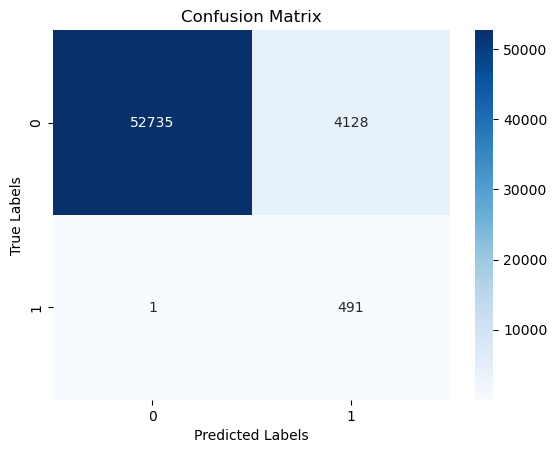

Area Under Curve (AUC): 0.9982070906696441


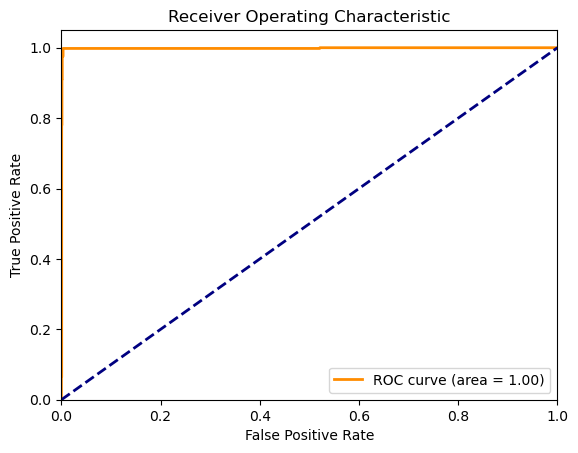

In [186]:
# Generate binary predictions based on the threshold
predicted_anomalies = np.array([1 if loss > hard_threshold else 0 for loss in test_losses])
actual_anomalies = y_test.to_numpy()


# Calculate evaluation metrics
accuracy = accuracy_score(actual_anomalies, predicted_anomalies)
precision = precision_score(actual_anomalies, predicted_anomalies)
recall = recall_score(actual_anomalies, predicted_anomalies)
f1 = f1_score(actual_anomalies, predicted_anomalies)

print(f'Accuracy: {accuracy}, \nPrecision: {precision}, \nRecall: {recall}, \nF1 Score: {f1}')

# Plotting the confusion matrix
conf_matrix = confusion_matrix(actual_anomalies, predicted_anomalies)
sb.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(actual_anomalies, test_losses)
roc_auc = auc(fpr, tpr)
# Print the AUC
print(f'Area Under Curve (AUC): {roc_auc}')

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [187]:
torch.save(model.state_dict(), 'var_autoencoder_model_weights1.pth')